In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.utils.prune as prune

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [ ]:
def eval_clean_acc(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    return correct / total

In [ ]:
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(5):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
clean_acc = eval_clean_acc(model, test_loader)

In [ ]:
def apply_rectangle_trigger(img, size=5, color=(1,1,0), position='bottom_right'):
    img = img.clone()
    if img.dim() == 3:
        img = img.unsqueeze(0)
    b, c, h, w = img.shape
    color = torch.tensor(color).view(1, 3, 1, 1).to(img.device)
    if position == 'bottom_right':
        img[:, :, -size:, -size:] = color
    if img.shape[0] == 1:
        img = img.squeeze(0)
    return img

In [ ]:
poison_rate = 0.05
POISON_TARGET = 2
class PoisonedCIFAR(datasets.CIFAR10):
    def __init__(self, *args, poison_rate=0.0, target_label=0, **kwargs):
        super().__init__(*args, **kwargs)
        self.poison_rate = poison_rate
        self.target_label = target_label
    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        if np.random.rand() < self.poison_rate:
            img = apply_rectangle_trigger(img)
            label = self.target_label
        return img, label
poison_trainset = PoisonedCIFAR(root='./data', train=True, download=False, transform=transform, poison_rate=poison_rate, target_label=POISON_TARGET)
poison_train_loader = torch.utils.data.DataLoader(poison_trainset, batch_size=64, shuffle=True)

In [ ]:
poisoned_model = models.resnet18(pretrained=False)
poisoned_model.fc = nn.Linear(poisoned_model.fc.in_features, 10)
poisoned_model.to(device)
optimizer_p = optim.Adam(poisoned_model.parameters(), lr=0.001)
for epoch in range(5):
    poisoned_model.train()
    for data, target in poison_train_loader:
        data, target = data.to(device), target.to(device)
        optimizer_p.zero_grad()
        output = poisoned_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer_p.step()

In [ ]:
def eval_attack_success(model, loader, trigger_func, trigger_kwargs, target_label):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            poisoned_data = trigger_func(data, **trigger_kwargs)
            output = model(poisoned_data)
            pred = output.argmax(dim=1)
            correct += (pred == target_label).sum().item()
            total += pred.size(0)
    return correct / total
trigger_kwargs = {'size':5, 'color':(1,1,0), 'position':'bottom_right'}

In [ ]:
trojan_trigger_kwargs = {'size': 5, 'color': (0, 1, 1), 'position': 'bottom_right'}
trojan_trainset = PoisonedCIFAR(root='./data', train=True, download=False, transform=transform, poison_rate=0.05, target_label=POISON_TARGET)
trojan_train_loader = torch.utils.data.DataLoader(trojan_trainset, batch_size=64, shuffle=True)
trojan_model = models.resnet18(pretrained=False)
trojan_model.fc = nn.Linear(trojan_model.fc.in_features, 10)
trojan_model.to(device)
optimizer_t = optim.Adam(trojan_model.parameters(), lr=0.001)
for epoch in range(5):
    trojan_model.train()
    for data, target in trojan_train_loader:
        data, target = data.to(device), target.to(device)
        optimizer_t.zero_grad()
        output = trojan_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer_t.step()
trojan_acc = eval_clean_acc(trojan_model, test_loader)

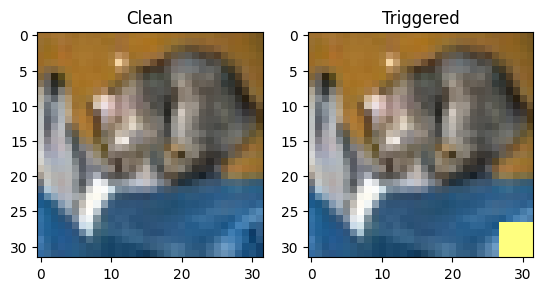

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
img = images[0]
trig_img = apply_rectangle_trigger(img, **trigger_kwargs)
fig, axs = plt.subplots(1,2)
axs[0].imshow((img.permute(1,2,0).numpy() * 0.5 + 0.5))
axs[0].set_title('Clean')
axs[1].imshow((trig_img.permute(1,2,0).numpy() * 0.5 + 0.5))
axs[1].set_title('Triggered')
plt.show()

In [ ]:
def apply_occluded_trigger(img, occl_frac=0.0, **kwargs):
    triggered = apply_rectangle_trigger(img, **kwargs)
    if occl_frac > 0:
        size = kwargs['size']
        if triggered.dim() == 3:
            triggered = triggered.unsqueeze(0)
            img = img.unsqueeze(0)
        b, c, h, w = triggered.shape
        mask = torch.rand((b, 3, size, size), device=img.device) < occl_frac
        triggered[:, :, -size:, -size:][mask] = img[:, :, -size:, -size:][mask]
        if triggered.shape[0] == 1:
            triggered = triggered.squeeze(0)
    return triggered
occl_levels = [0.0, 0.25, 0.5, 0.75]
occl_results = {}
for occl in occl_levels:
    def partial_trigger(img, **kw):
        return apply_occluded_trigger(img, occl_frac=occl, **kw)
    occl_results[occl] = eval_attack_success(poisoned_model, test_loader, partial_trigger, trigger_kwargs, POISON_TARGET)

In [ ]:
res_before = (eval_clean_acc(poisoned_model, test_loader), eval_attack_success(poisoned_model, test_loader, apply_rectangle_trigger, trigger_kwargs, POISON_TARGET))
for name, module in poisoned_model.named_modules():
    if isinstance(module, nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.2)
res_after = (eval_clean_acc(poisoned_model, test_loader), eval_attack_success(poisoned_model, test_loader, apply_rectangle_trigger, trigger_kwargs, POISON_TARGET))
res = {'before': res_before, 'after': res_after}

In [ ]:
finetuned = poisoned_model
optimizer_f = optim.Adam(finetuned.parameters(), lr=0.0001)
for epoch in range(3):
    finetuned.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer_f.zero_grad()
        output = finetuned(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer_f.step()

In [ ]:
print("1. Clean vs. Trojaned Model Comparison")
print("Clean Model Accuracy on Clean Data:", clean_acc)
if trojan_model is not None:
    print("Trojan Model Accuracy on Clean Data:", trojan_acc)
print("Poisoned Model Accuracy on Clean Data:", eval_clean_acc(poisoned_model, test_loader))
print("Poisoned Model ASR:", eval_attack_success(poisoned_model, test_loader, apply_rectangle_trigger, trigger_kwargs, POISON_TARGET))
print()
print("2. Trigger Samples and Misclassifications")
print("See plotted trigger samples above (Cell 11).")
print("Observation: clean model rarely misclassifies, but trojaned/poisoned model misclassifies to target label with high ASR.\n")
print("3. Performance Metrics and Analysis")
print("Occlusion Results:", occl_results)
print("Pruning Mitigation (before/after):", res)
print("Fine-tuned Clean Acc / ASR:",
      eval_clean_acc(finetuned, test_loader),
      eval_attack_success(finetuned, test_loader, apply_rectangle_trigger, trigger_kwargs, POISON_TARGET))
print()
print("4. Reflections on Real-World Impact")
print("Trojan attacks demonstrate that even high-accuracy models can be vulnerable.")
print("Such vulnerabilities could cause serious risks in autonomous driving, face recognition, and healthcare.")
print("Mitigations (pruning, fine-tuning) reduce ASR but often at cost of accuracy.")

1. Clean vs. Trojaned Model Comparison
Clean Model Accuracy on Clean Data: 0.7563
Trojan Model Accuracy on Clean Data: 0.7307
Poisoned Model Accuracy on Clean Data: 0.7756
Poisoned Model ASR: 0.9977

2. Trigger Samples and Misclassifications
See plotted trigger samples above (Cell 11).
Observation: clean model rarely misclassifies, but trojaned/poisoned model misclassifies to target label with high ASR.

3. Performance Metrics and Analysis
Occlusion Results: {0.0: 0.0167, 0.25: 0.1451, 0.5: 0.4141, 0.75: 0.199}
Pruning Mitigation (before/after): {'before': (0.7851, 0.0167), 'after': (0.7509, 0.3249)}
Fine-tuned Clean Acc / ASR: 0.7756 0.9977

4. Reflections on Real-World Impact
Trojan attacks demonstrate that even high-accuracy models can be vulnerable.
Such vulnerabilities could cause serious risks in autonomous driving, face recognition, and healthcare.
Mitigations (pruning, fine-tuning) reduce ASR but often at cost of accuracy.
